In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers

from sklearn.model_selection import train_test_split,StratifiedKFold
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from keras.callbacks import ModelCheckpoint,ReduceLROnPlateau

2024-08-26 13:43:01.177659: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 13:43:01.727446: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-26 13:43:01.730296: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-26 13:43:03.808390: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-08-26 13:43:08.220417: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


# 10 state

## Load

In [ ]:
x=np.load('/pscratch/sd/n/nrvora/Data/Quantum/20240711/train-001.npy')

In [ ]:
INTEGRATION_LENGTH = 2200
integeration_start = 142


with open('/pscratch/sd/n/nrvora/Data/Quantum/20240711/train-001.npy', 'rb') as file:
    train_data = np.load(file, allow_pickle=False)[:,:, integeration_start:integeration_start+INTEGRATION_LENGTH]

n_reps, n_levels, n_sample_points = train_data.shape


train_label = np.array([[[l] for l in range(n_levels)] for _ in range(n_reps)])
train_data_acc = train_data.mean(axis=-1)


with open('/pscratch/sd/n/nrvora/Data/Quantum/20240711/test.npy', 'rb') as file:
    test_data = np.load(file, allow_pickle=False)[:,:, integeration_start:integeration_start+INTEGRATION_LENGTH]

n_reps, n_levels, n_sample_points = test_data.shape


test_label = np.array([[[l] for l in range(n_levels)] for _ in range(n_reps)])
test_data_acc = test_data.mean(axis=-1)

## Analysis

In [ ]:
state0  = x[:,0,:]
state1  = x[:,1,:]
state2  = x[:,2,:]

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.mean(state0[:,st:ed],axis=0), label='Mean Signal')
plt.fill_between(np.arange(4000), np.mean(state0[:,st:ed],axis=0) - np.std(state0[:,st:ed],axis=0), np.mean(state0[:,st:ed],axis=0) + np.std(state0[:,st:ed],axis=0), color='red', alpha=0.3, label='Standard Deviation')
plt.title('Mean and Standard Deviation of Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
ratio_mean_std = np.std(state0[:,st:ed],axis=0)/np.mean(state0[:,st:ed],axis=0)
ratio_mean_std

In [ ]:
st,ed=0,4000
t=np.arange(0e-9,4e-6,1e-9)

plt.plot(t,state0[5,st:ed],alpha=0.2,c='b')
plt.plot(t,state1[5,st:ed],alpha=0.5,c='orange')

plt.plot(t,np.mean(state0[:,st:ed],axis=0),alpha=0.5,c='b', label='state0')
plt.plot(t,np.mean(state1[:,st:ed],axis=0),alpha=0.9,c='orange', label='state1')
plt.legend()


In [ ]:
plt.plot(t,np.convolve(np.mean(state0,axis=0), np.ones(100)/100, mode='same'))
plt.plot(t,np.convolve(np.mean(state1,axis=0), np.ones(100)/100, mode='same'))
plt.plot(t,np.convolve(np.mean(state2,axis=0), np.ones(100)/100, mode='same'))

# plt.plot(t,np.convolve(state0[5], np.ones(100)/100, mode='same'))
# plt.plot(t,np.convolve(state1[5], np.ones(100)/100, mode='same'))
# plt.plot(t,np.convolve(state2[5], np.ones(100)/100, mode='same'))
## NN

In [ ]:
train_data.shape,train_label.shape

In [ ]:
x=train_data.reshape(-1,train_data.shape[-1])
X=np.hstack((x.real,x.imag))
y=train_label.reshape(-1)
X.shape, y.shape

In [ ]:
y = to_categorical(y, num_classes=10)
y.shape

In [ ]:
model = Sequential()
model.add(layers.Input(shape=(4400,), name='Input_Layer'))
model.add(layers.Dense(16, activation='relu', name='Hidden_Layer_1'))
# model.add(layers.Dense(16, activation='relu', name='Hidden_Layer_2'))
# model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax', name='Output_Layer'))


# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

model_path="model/{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]




In [ ]:
# Train the model
model.fit(X, y, epochs=100, batch_size=1024, validation_split=0.2, callbacks=callbacks_list)

In [ ]:
x_test=test_data.reshape(-1,test_data.shape[-1])
X_test=np.hstack((x_test.real,x_test.imag))
y_test=test_label.reshape(-1)
y_test = to_categorical(y_test, num_classes=10)
X_test.shape, y_test.shape

In [ ]:
model = load_model('model/45-0.2302-0.9387.h5', compile=False)
Y_pred = model.predict(X_test)

# Convert one-hot encoded predictions back to label format
Y_test_labels = np.argmax(y_test, axis=1)
Y_pred_labels = np.argmax(Y_pred, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(Y_test_labels, Y_pred_labels)

# Normalize the confusion matrix to percentage
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Display the normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix (in Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(10), labels=np.arange(10))
plt.yticks(np.arange(10), labels=np.arange(10))
plt.show()

accuracy = accuracy_score(Y_test_labels, Y_pred_labels)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

In [ ]:
conf_matrix

# 3state

In [36]:
state0 = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state0.npy')[:,1100:2700]
state1 = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state1.npy')[:,1100:2700]
state2 = np.load('/pscratch/sd/n/nrvora/Data/Quantum/longterm/dlo_state2.npy')[:,1100:2700]
output0=np.zeros((state0.shape[0]))
output1=np.ones((state1.shape[0]))
output2=np.array((2,)*state2.shape[0])

trainData = np.vstack((state0,state1,state2))
trainLabel = np.hstack((output0,output1,output2))

trainData.shape, trainLabel.shape


((36000, 1600), (36000,))

## Analysis

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(np.mean(state0[:,st:ed],axis=0), label='Mean Signal')
plt.fill_between(np.arange(4000), np.mean(state0[:,st:ed],axis=0) - np.std(state0[:,st:ed],axis=0), np.mean(state0[:,st:ed],axis=0) + np.std(state0[:,st:ed],axis=0), color='red', alpha=0.3, label='Standard Deviation')
plt.title('Mean and Standard Deviation of Signal')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
ratio_mean_std = np.std(state0[:,st:ed],axis=0)/np.mean(state0[:,st:ed],axis=0)
ratio_mean_std

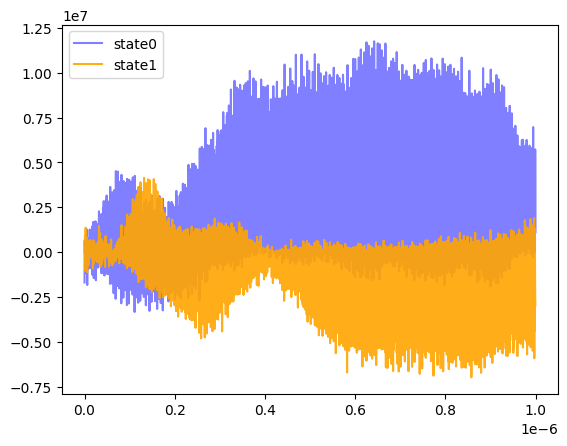

In [43]:
t=np.arange(0e-9,1e-6,0.5e-9)

# plt.plot(t,state0[5],alpha=0.2,c='b')
# plt.plot(t,state1[5],alpha=0.5,c='orange')
# plt.plot(t,state2[5,st:ed],alpha=0.09,c='g')

plt.plot(t,np.mean(state0,axis=0),alpha=0.5,c='b',label='state0')
plt.plot(t,np.mean(state1,axis=0),alpha=0.9,c='orange',label='state1')
# plt.plot(t,np.mean(state2[:,st:ed],axis=0),alpha=0.3,c='g')

plt.legend()


In [ ]:
st,ed=1200,3000
window=100
trc0I=np.add.reduceat(np.mean((state0[:,st:ed]),axis=0).real, range(0,ed-st,window),axis=0)/float(window)
trc0Q=np.add.reduceat(np.mean((state0[:,st:ed]),axis=0).imag, range(0,ed-st,window),axis=0)/float(window)
trc1I=np.add.reduceat(np.mean((state1[:,st:ed]),axis=0).real, range(0,ed-st,window),axis=0)/float(window)
trc1Q=np.add.reduceat(np.mean((state1[:,st:ed]),axis=0).imag, range(0,ed-st,window),axis=0)/float(window)
trc2I=np.add.reduceat(np.mean((state2[:,st:ed]),axis=0).real, range(0,ed-st,window),axis=0)/float(window)
trc2Q=np.add.reduceat(np.mean((state2[:,st:ed]),axis=0).imag, range(0,ed-st,window),axis=0)/float(window)

plt.plot(trc0I, trc0Q, marker='o', label='State 0')
plt.plot(trc1I, trc1Q, marker='o', label='State 1')
plt.plot(trc2I, trc2Q, marker='o', label='State 2')

## NN

In [37]:
X=np.stack((trainData.real,trainData.imag))
y=trainLabel.reshape(-1)
X.shape, y.shape

((2, 36000, 1600), (36000,))

In [38]:
size_bin=64
nums_bin = X.shape[2]//size_bin
binI,binQ=[],[]
for i in range(nums_bin):
    st=i*size_bin
    ed=st+size_bin
    binI.append(np.mean(X[0,:,st:ed],axis=-1))
    binQ.append(np.mean(X[1,:,st:ed],axis=-1))
binI=np.array(binI).T
binQ=np.array(binQ).T
X=np.hstack((binI,binQ))

In [39]:
X.shape

(36000, 50)

In [40]:
mean = np.mean(X, axis=0)
std = np.std(X, axis=0)
X_standardized = (X - mean) / std

X_standardized.shape

(36000, 50)

In [41]:
y = to_categorical(y, num_classes=3)

x_train, x_test, y_train, y_test = train_test_split(X_standardized, y, test_size=0.30, random_state=45)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)

(25200, 50)
(10800, 50)
(25200, 3)


In [42]:
model = Sequential()
model.add(layers.Input(shape=(x_train.shape[1],), name='Input_Layer'))
model.add(layers.Dense(16, activation='relu', name='Hidden_Layer_1'))
model.add(layers.Dense(3, activation='softmax', name='Output_Layer'))


# Compile the model
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print the model summary
model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.0001)

model_path="model2/{epoch:02d}-{val_loss:.4f}-{val_accuracy:.4f}.h5"
checkpoint = ModelCheckpoint(model_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Hidden_Layer_1 (Dense)      (None, 16)                816       
                                                                 
 Output_Layer (Dense)        (None, 3)                 51        
                                                                 
Total params: 867 (3.39 KB)
Trainable params: 867 (3.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [32]:
model.fit(x_train, y_train, epochs=100, batch_size=512, validation_split=0.2, 
          callbacks=callbacks_list
          )

Epoch 1/100
 1/40 [..............................] - ETA: 12s - loss: 1.5232 - accuracy: 0.2031
Epoch 1: val_accuracy improved from -inf to 0.77877, saving model to model2/01-0.6617-0.7788.h5
40/40 [==============================] - 1s 5ms/step - loss: 1.0238 - accuracy: 0.4953 - val_loss: 0.6617 - val_accuracy: 0.7788
Epoch 2/100
 1/40 [..............................] - ETA: 0s - loss: 0.6449 - accuracy: 0.7793
Epoch 2: val_accuracy improved from 0.77877 to 0.92917, saving model to model2/02-0.3660-0.9292.h5
40/40 [==============================] - 0s 3ms/step - loss: 0.4934 - accuracy: 0.8785 - val_loss: 0.3660 - val_accuracy: 0.9292
Epoch 3/100
 1/40 [..............................] - ETA: 0s - loss: 0.3342 - accuracy: 0.9395

/global/homes/n/nrvora/.conda/envs/readout/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 3: val_accuracy improved from 0.92917 to 0.94802, saving model to model2/03-0.2599-0.9480.h5
40/40 [==============================] - 0s 3ms/step - loss: 0.3066 - accuracy: 0.9418 - val_loss: 0.2599 - val_accuracy: 0.9480
Epoch 4/100
 1/40 [..............................] - ETA: 0s - loss: 0.2199 - accuracy: 0.9688
Epoch 4: val_accuracy improved from 0.94802 to 0.95456, saving model to model2/04-0.2234-0.9546.h5
40/40 [==============================] - 0s 4ms/step - loss: 0.2440 - accuracy: 0.9509 - val_loss: 0.2234 - val_accuracy: 0.9546
Epoch 5/100
 1/40 [..............................] - ETA: 0s - loss: 0.2103 - accuracy: 0.9609
Epoch 5: val_accuracy improved from 0.95456 to 0.95635, saving model to model2/05-0.2077-0.9563.h5
40/40 [==============================] - 0s 3ms/step - loss: 0.2216 - accuracy: 0.9534 - val_loss: 0.2077 - val_accuracy: 0.9563
Epoch 6/100
 1/40 [..............................] - ETA: 0s - loss: 0.2158 - accuracy: 0.9570
Epoch 6: val_accuracy improved

68/68 [==============================] - 0s 534us/step


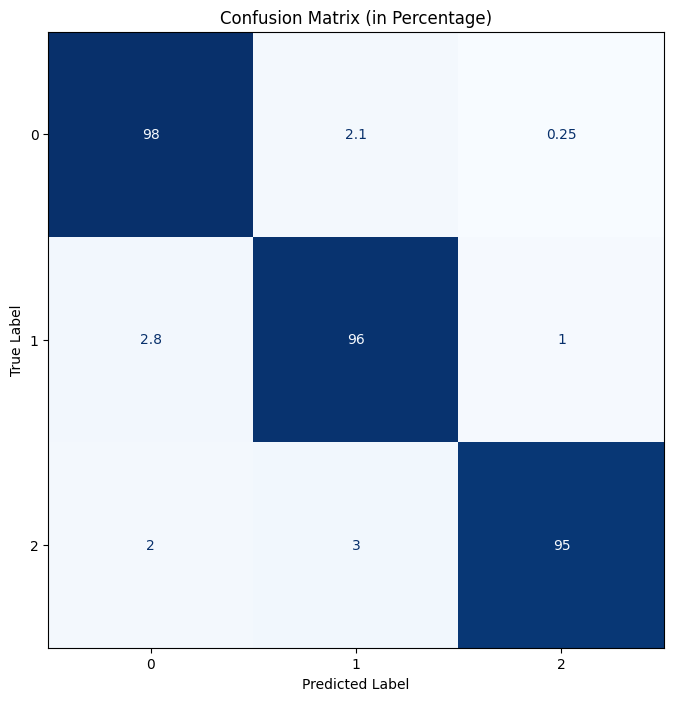

Test Accuracy: 96.27% ± 0.26%


In [35]:
model = load_model('/global/homes/n/nrvora/Projects/Quantum/multi_state/model2/42-0.1585-0.9621.h5', compile=False)
num_folds = 5
skf = StratifiedKFold(n_splits=num_folds)
accuracies = []
conf_matrices = []

for train_index, test_index in skf.split(x_test, np.argmax(y_test, axis=1)):
    x_train_fold, x_test_fold = x_test[train_index], x_test[test_index]
    y_train_fold, y_test_fold = y_test[train_index], y_test[test_index]
    
    Y_pred_fold = model.predict(x_test_fold)
    Y_test_labels_fold = np.argmax(y_test_fold, axis=1)
    Y_pred_labels_fold = np.argmax(Y_pred_fold, axis=1)
    
    accuracy = accuracy_score(Y_test_labels_fold, Y_pred_labels_fold)
    accuracies.append(accuracy)
    
    conf_matrix_fold = confusion_matrix(Y_test_labels_fold, Y_pred_labels_fold)
    conf_matrices.append(conf_matrix_fold)

mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

# Calculate the mean and std deviation of confusion matrices
mean_conf_matrix = np.mean(conf_matrices, axis=0)
std_conf_matrix = np.std(conf_matrices, axis=0)

# Normalize the mean confusion matrix to percentage
conf_matrix_normalized = mean_conf_matrix.astype('float') / mean_conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot the mean confusion matrix with error bars
fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_normalized, display_labels=np.arange(3))
disp.plot(cmap=plt.cm.Blues, ax=ax, colorbar=False)

plt.title('Confusion Matrix (in Percentage)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(3), labels=np.arange(3))
plt.yticks(np.arange(3), labels=np.arange(3))
plt.show()

# Print the mean accuracy with error bars
print(f'Test Accuracy: {mean_accuracy * 100:.2f}% ± {std_accuracy * 100:.2f}%')